<a href="https://colab.research.google.com/github/goutam1469/ANLP/blob/main/ANLPassignment2024_292245.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANLP Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [ ]:
candidateno=292245 #this MUST be updated to your candidate number so that you get a unique data sample


In [ ]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [ ]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the
            pair is a list of the training data and the second is a list of the test data.
    """

    data = list(data)
    n = len(data)
    train_indices = random.sample(range(n), int(n * ratio))
    test_indices = list(set(range(n)) - set(train_indices))
    train = [data[i] for i in train_indices]
    test = [data[i] for i in test_indices]
    return (train, test)


def get_train_test_data():

    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')

    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]

    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [ ]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['most', 'movies', 'seem', 'to', 'release', 'a', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

###Pre Processing Data

The function norm_data() pre-processes the data like : lowering, normalization, stemming, stopword & punctuation removal

In [ ]:
from nltk.stem import PorterStemmer
from nltk import FreqDist
from nltk.corpus import stopwords

punc = ['.',',','"',"'",';',':',')','(','!','-','_','?','/']
ps = PorterStemmer()
sw = stopwords.words('english')


def norm_data(text):
  text = [word.lower() for word in text]
  text = ["num" if word.isdigit() else word for word in text]
  text = [ps.stem(word) for word in text]
  text = [word for word in text if word not in punc]
  text = [word for word in text if word not in sw]
  return text

pos_training = [norm_data(corpus[0]) for corpus in training_data if corpus[1]=='pos']
neg_training = [norm_data(corpus[0]) for corpus in training_data if corpus[1]=='neg']



###Creating positive and negative word list

In [ ]:
pos_list = [word for text in pos_training for word in text]
neg_list = [word for text in neg_training for word in text]

freq_pos_training = FreqDist(pos_list)
freq_neg_training = FreqDist(neg_list)


In [ ]:
#Creating positive and negative exclusive words

pos_content_words = [text for text, freq in freq_pos_training.items() if text not in neg_list]
neg_content_words = [text for text, freq in freq_neg_training.items() if text not in pos_list]


In [ ]:
print(f"Positive content words : {pos_content_words[:10]}")
print(f"Negative content words : {neg_content_words[:10]}")

Positive content words : ['thunderlip', 'clubber', 'meredith', 'smocki', 'entertan', 'adriann', 'showi', 'unobtrus', 'oversimplifi', 'unrestrain']
Negative content words : ['pejor', 'falwel', 'fret', 'forb', 'mathew', 'mconaughi', 'bongo', 'coitu', 'copul', 'workweek']


2)
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


#### The class SimpleClassifier defines a simple classifier that predicts sentiment as either "positive" ("pos") or "negative" ("neg") based on word lists. In classify, it scores a given set of words: adding to the score for words in a positive list (_pos) and subtracting for words in a negative list (_neg). If the final score is negative, it classifies as "neg"; otherwise, "pos."

In [ ]:
from nltk.classify.api import ClassifierI
import random

class SimpleClassifier(ClassifierI):

    def __init__(self, pos, neg):
        self._pos = pos
        self._neg = neg

    def classify(self, words):
        score = 0

        for word in words :
          if word in self._pos:
            score+=1
          elif word in self._neg:
            score-=1
        return "neg" if score < 0 else "pos"

    def labels(self):
        return ("pos", "neg")


#example
classifier = SimpleClassifier(pos_content_words, neg_content_words)
classifier.classify(FreqDist("This movie was good".split()))

'pos'

In [ ]:
predicted = [classifier.classify(FreqDist(text[0])) for text in testing_data]
actual = [text[1] for text in testing_data]

3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

The class ConfusionMatrix to evaluate a classifier’s performance on binary classification (e.g., "pos" vs. "neg").

Initialization (__init__): Takes predictions and goldstandard (true labels) and counts the instances for:

TP (True Positives): correctly predicted as positive.
FP (False Positives): predicted as positive but actually negative.
FN (False Negatives): predicted as negative but actually positive.
TN (True Negatives): correctly predicted as negative.
precision(): Calculates precision (TP / (TP + FP)), which is the accuracy of positive predictions.

recall(): Calculates recall (TP / (TP + FN)), which is the coverage of actual positives.

f1(): Calculates the F1 score, the harmonic mean of precision and recall.

In [ ]:
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=("pos","neg")):

        (self.c1,self.c2)=classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1

            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1


    def precision(self):
        p=0
        if self.TP + self.FP == 0:
          p=0
        else :
          p = self.TP/(self.TP + self.FP)

        return p

    def recall(self):
        r=0
        if self.TP + self.FN ==0:
          r=0
        else :
          r=self.TP/(self.TP+self.FN)

        return r

    def f1(self):
        f1=0
        p=self.precision()
        r=self.recall()
        if p+r ==0:
          f1=0
        else :
          f1=(2*p*r)/(p+r)

        return f1

In [ ]:
cm = ConfusionMatrix(predicted, actual)

In [ ]:
actual[:5]

['pos', 'pos', 'pos', 'pos', 'pos']

In [ ]:
cm.f1()

0.7063953488372093

4)
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results.

[12.5\%]

This NBClassifier class builds a Naive Bayes text classifier:

_set_known_vocabulary: Collects all unique words from the training data.

_set_priors: Calculates prior probabilities for each class based on training data labels.

_set_cond_probs: Calculates conditional probabilities of each word given a class with Laplace smoothing.

train: Calls helper methods to initialize vocabulary, priors, and conditional probabilities.

classify: Computes log-probabilities for each class based on priors and word probabilities in the document, then returns the class with the highest score.

In [ ]:
#Constructing Naive Bayes Classifier

import math
from nltk.classify.api import ClassifierI

class NBClassifier(ClassifierI):

    def __init__(self):

        pass

    def _set_known_vocabulary(self,training_data):
        known=[]
        for doc,label in training_data:
            known+=list(doc.keys())
        self.known= set(known)

    def _set_priors(self,training_data):
        priors={}
        for (doc,label) in training_data:
            priors[label]=priors.get(label,0)+1
        total=sum(priors.values())
        for key,value in priors.items():
            priors[key]=value/total
        self.priors=priors

    def _set_cond_probs(self,training_data):
        conds={}
        for(doc,label) in training_data:
            classcond=conds.get(label,{})
            for word in doc.keys():
                classcond[word]=classcond.get(word,0)+1

            conds[label]=classcond

        for label, classcond in conds.items():
            for word in self.known:

                classcond[word]=classcond.get(word,0)+1
            conds[label]=classcond

        for label,dist in conds.items():
            total=sum(dist.values())
            conds[label]={key:value/total for (key,value) in dist.items()}

        self.conds=conds

    def train(self,training_data):
        self._set_known_vocabulary(training_data)
        self._set_priors(training_data)
        self._set_cond_probs(training_data)

    def classify(self,doc):
        doc_probs={key:math.log(value) for (key,value) in self.priors.items()}
        for word in doc.keys():
            if word in self.known:
                doc_probs={classlabel:sofar+math.log(self.conds[classlabel].get(word,0)) for (classlabel,sofar) in doc_probs.items()}

        highprob=max(doc_probs.values())
        classes=[c for c in doc_probs.keys() if doc_probs[c]==highprob]
        return random.choice(classes)




In [ ]:

training_norm=[(FreqDist(norm_data(wordlist)),label) for (wordlist,label) in training_data] #creating freqdist of training data
testing_norm=[(FreqDist(norm_data(wordlist)),label) for (wordlist,label) in testing_data]   #creating freqdist of testing data

In [ ]:
myclassifier=NBClassifier()
myclassifier.train(training_norm)
predictions_naivebayes = myclassifier.classify_many(doc for (doc,label) in testing_norm)
docs,labels=zip(*testing_norm)
senti_cm_naivebayes=ConfusionMatrix(predictions_naivebayes,labels)


In [ ]:
acc = (senti_cm_naivebayes.TP + senti_cm_naivebayes.TN)/len(predictions_naivebayes)
acc  #Accuracy

0.8233333333333334

In [ ]:
#Precision
senti_cm_naivebayes.precision()

0.8344827586206897

In [ ]:
#Recall
senti_cm_naivebayes.recall()

0.81

In [ ]:
#F1 Score
senti_cm_naivebayes.f1()

0.8279386712095401

5)
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions.

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


This len_wordlist function:

Loops through different word list sizes (alist).
Trains a SimpleClassifier using corresponding positive and negative word lists.
Classifies each document in testing_data and computes the predictions.
Calculates accuracy and F1 score using a ConfusionMatrix.
Returns lists of accuracy and F1 scores for each word list size.

In [ ]:
import seaborn as sns

alist = [10,50,100,150,200,250,300,350,400,500,600,700,800,900,1000]
def len_wordlist(alist):
  accuracy = []
  f1 = []

  for i in alist:
    classifier = SimpleClassifier(pos_content_words[i], neg_content_words[i])
    predicted = [classifier.classify(FreqDist(text[0])) for text in testing_data]
    actual = [text[1] for text in testing_data]
    cm = ConfusionMatrix(predicted, actual)
    accuracy.append((cm.TP+cm.TN)/len(testing_data))
    f1.append(cm.f1())

  return accuracy, f1

In [ ]:
accuracy, f1 = len_wordlist(alist)

In [ ]:
print(f1)
print(accuracy)

[0.6606741573033709, 0.5656565656565656, 0.41316270566727603, 0.643985419198056, 0.39089184060721066, 0.6170212765957447, 0.5784695201037613, 0.5639445300462249, 0.6651835372636262, 0.6689113355780022, 0.2021276595744681, 0.08849557522123894, 0.6666666666666666, 0, 0.3639921722113502]
[0.49666666666666665, 0.49833333333333335, 0.465, 0.5116666666666667, 0.465, 0.52, 0.4583333333333333, 0.5283333333333333, 0.49833333333333335, 0.5083333333333333, 0.5, 0.485, 0.5, 0.49833333333333335, 0.4583333333333333]


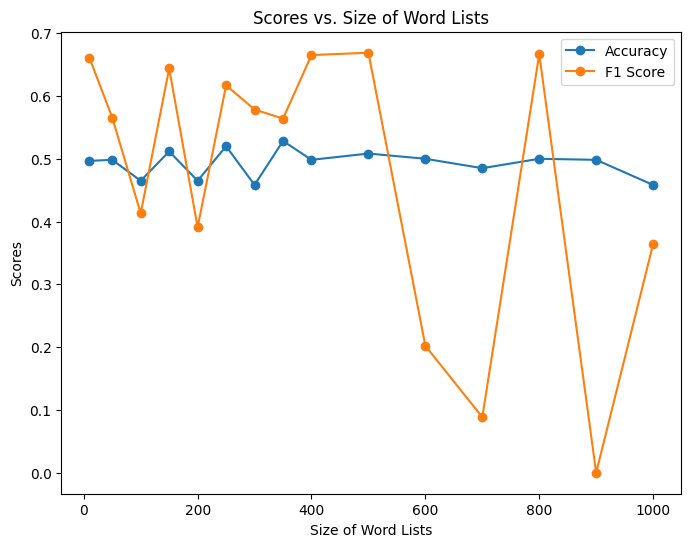

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(alist, accuracy, marker='o', label='Accuracy')
plt.plot(alist, f1, marker='o', label='F1 Score')
plt.xlabel('Size of Word Lists')
plt.ylabel('Scores')
plt.title('Scores vs. Size of Word Lists')
plt.legend()
plt.show()

I recommend using a Naive Bayes classifier over a wordlist classifier because it is more scalable, flexible, and can handle unseen data. Naive Bayes adapts to new data and provides better accuracy, while wordlist classifiers are static, limited, and fail to generalize well.

In [ ]:
##This code will word count all of the markdown cells in the notebook saved at filepath

import io
from nbformat import current

from google.colab import drive
drive.mount('/content/drive')

filepath="/content/drive/MyDrive/Colab Notebooks/ANLPassignment2024.ipynb"
question_count=432

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

MessageError: Error: credential propagation was unsuccessful